# Bitcoin Forecasting

Hi! I answered the questions below:

**Does this data set even make sense? What are the limitations of this data set?**

It would make more sense to me to use more data from all times of the day and from several days to capture any seasonality and trends. Predictions on a longer timeframe e.g. next hour or day may also be easier to execute on (with enough training data) than buying or selling on a second-basis (which may be too fast to execute trades). BTC is traded 24 hours a day so we could build a more robust model with data from all hours of the day thereby capture many possible time dynamics.

**Is the lookback window of 60 seconds helpful? What are its limitations? What other features would you want to see in this data set?**
The lookback window was helpful. The limitations are that for each lagged value, data the size of the window is removed. A 60 -sec lookback means that we can’t include the past 60 datapoints into our training set. Since our data is limited, we cannot compute endless lookbacks. The 10-60 sec moving averages of the various features may have been helpful to predicting the target variable. 

**If you stuck with the neural network, what did you change to make it better? Did you change the architecture, did you change the optimizer? The learning rate? The activation function(s)? Why was the model stuck at 0 with an incredibly high root mean squared error?**
I made some changes to the orginal NN but your layout was a great start. I kept the general architecture but changed the size and activation function of some layers. For example, I changed the activation function of the 1st, 2nd layers to Rectified Linear Unit (ReLu) to incorporate more non-linearity into the model. Additionally, I made the 2nd layer 164 neurons and removed the activation function for the final layer. I agreed with the use of Adam algorithm as optimizer, because it has a fast computation time and require fewer tuning parameters. The learning rate of 0.01 seemed to work fine, but I would consider changing it if training loss did not decrease within 50-100 epochs. Using MSE (or RSME) as the loss and evaluation metric also made sense for this regression problem. Accuracy would not be appropriate in this context (that is for a non-classification problem). I implemented the early stopping callback so that the model stops training when the validation loss stops decreasing. The model was unable to decrease its training or validation loss within the 20 epochs specified so it needed a longer training time, larger learning rate, different sized layers, more ReLu activation functions in the layers or a combination thereof to avoid getting stuck at 0. 

**If you used a different model, why'd you choose this model? What about it made it work for this problem? Is this model complex and if so, is the complexity necessary? Is it intuitive enough to explain it to a lay-person? What was your optimizing metric? What were the hyperparameters and why'd you choose them?**

I choose to use a linear regression and gradient boosted tree algorithm to predict the price_high target variable (as a regression problem). The Linear regression model is the less complex model of the 2 and gave similar performance (or RSME values) so I would progress with this model because it is easier to explain to lay-people than the xgboost model. The lookback window function provided several rich engineered, tabular-structured features to use, which the linear regression model is well-suited to handle. I added the top 10 feature importance barplot to help illustrate how the linear regression model predicts its output. Coefficients with higher absolute values of importance will have a greater effect on the target variable. Positive coefficients will increase the target variable whereas negative coefficients will decrease the target variables. Two features (price_close and price_open) were critical to increasing the value of price_high, whereas many of the lagged features contributed very little to the output. Linear Regression minimized mean squared error to calculate the optimal set of coefficients. I used the default hyperparameters as a start, as I found these hyperparameters to be reasonable choices in my experience. Given more time/data, I would limit the linear regression model to the top 10 features for a leaner model with equivalent performance.

The gradient boosted tree algorithm has fast computation speeds and robust performance (through improved regularization). Xgboost uses an ensemble of decision trees to make its output generalize better to new data because it is not as prone to overfitting as its individual learners (trees). Xgboost model uses decision trees (which are very interpretable & explainable) to predict its output. Additionally, I performed a Shapley analysis to help demonstrate interpretability and explicability of the xgboost model. 

**Did you include visualizations? (everyone loves a good graphic)**

Yes, I did – please see the notebook and above for explanations. 

**How do we know the model is good? How understandable are the diagnostics? How will we know how good the model is predicting in production?**

I plotted the predicted and actual timeseries data so that we can see for ourselves whether the predictions align over the entire timeseries. I also calculated the test RMSE as an evaluation of the models’ performance – enabling comparison among models. The model is good for production when the predictions have as low a RSME as possible and the test RMSE is slightly less than the training RSME (so that we know that the model is not overfit and will generalize to new data).



## EDA

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [2]:
data = pd.read_csv('bitcoin.csv')
df = data.drop(['time_period_start', 'time_period_end', 'time_open', 'time_close'], axis=1)
data

,time_period_start,time_period_end,time_open,time_close,price_open,price_high,price_low,price_close,volume_traded,trades_count
0,2020-01-01T00:00:00.0000000Z,2020-01-01T00:00:01.0000000Z,2020-01-01T00:00:00.2222560Z,2020-01-01T00:00:00.8221530Z,7165.72,7165.72,7165.71,7165.71,0.021841,2
1,2020-01-01T00:00:01.0000000Z,2020-01-01T00:00:02.0000000Z,2020-01-01T00:00:01.9490000Z,2020-01-01T00:00:01.9530000Z,7168.30,7168.30,7168.30,7168.30,1.000000,2
2,2020-01-01T00:00:02.0000000Z,2020-01-01T00:00:03.0000000Z,2020-01-01T00:00:02.5550000Z,2020-01-01T00:00:02.5550000Z,7170.50,7170.50,7170.50,7170.50,0.002000,1
3,2020-01-01T00:00:04.0000000Z,2020-01-01T00:00:05.0000000Z,2020-01-01T00:00:04.1710000Z,2020-01-01T00:00:04.5600000Z,7169.20,7169.20,7169.20,7169.20,0.004000,2
4,2020-01-01T00:00:05.0000000Z,2020-01-01T00:00:06.0000000Z,2020-01-01T00:00:05.3790000Z,2020-01-01T00:00:05.3790000Z,7169.20,7169.20,7169.20,7169.20,0.002000,1
...,...,...,...,...,...,...,...,...,...,...
9995,2020-01-01T08:07:45.0000000Z,2020-01-01T08:07:46.0000000Z,2020-01-01T08:07:45.1424370Z,2020-01-01T08:07:45.1424370Z,7179.50,7179.50,7179.50,7179.50,0.013325,1
9996,2020-01-01T08:07:53.0000000Z,2020-01-01T08:07:54.0000000Z,2020-01-01T08:07:53.8880000Z,2020-01-01T08:07:53.8880000Z,7181.67,7181.67,7181.67,7181.67,0.013364,1
9997,2020-01-01T08:07:57.0000000Z,2020-01-01T08:07:58.0000000Z,2020-01-01T08:07:57.5449170Z,2020-01-01T08:07:57.5449170Z,7179.50,7179.50,7179.50,7179.50,0.001526,1
9998,2020-01-01T08:07:58.0000000Z,2020-01-01T08:07:59.0000000Z,2020-01-01T08:07:58.3860000Z,2020-01-01T08:07:58.3860000Z,7182.12,7182.12,7182.12,7182.12,0.013437,1


In [3]:
df.shape

(10000, 6)

In [4]:
df.describe()

,price_open,price_high,price_low,price_close,volume_traded,trades_count
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,7190.667163,7190.891258,7190.445922,7190.663989,0.316941,1.748300
std,18.318254,18.311377,18.356907,18.341736,1.810771,2.215815
min,7144.620000,7144.620000,7136.050000,7144.620000,0.000008,1.000000
25%,7184.950000,7185.000000,7184.757500,7184.887500,0.006210,1.000000
50%,7196.970000,7197.310000,7196.640000,7196.960000,0.015223,1.000000
75%,7203.250000,7203.400000,7203.010000,7203.250000,0.068103,2.000000
max,7223.500000,7224.530000,7223.400000,7223.500000,65.014193,88.000000


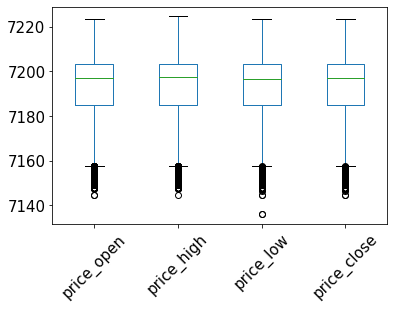

In [5]:
df.boxplot(column=["price_open",'price_high','price_low','price_close'],grid=False, rot=45, fontsize=15)

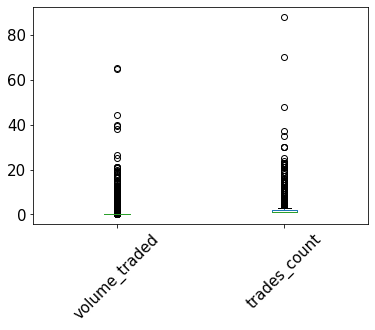

In [6]:
df.boxplot(column=['volume_traded','trades_count'],grid=False, rot=45, fontsize=15)

In [7]:
df.info

<bound method DataFrame.info of       price_open  price_high  price_low  price_close  volume_traded  \
0        7165.72     7165.72    7165.71      7165.71       0.021841   
1        7168.30     7168.30    7168.30      7168.30       1.000000   
2        7170.50     7170.50    7170.50      7170.50       0.002000   
3        7169.20     7169.20    7169.20      7169.20       0.004000   
4        7169.20     7169.20    7169.20      7169.20       0.002000   
...          ...         ...        ...          ...            ...   
9995     7179.50     7179.50    7179.50      7179.50       0.013325   
9996     7181.67     7181.67    7181.67      7181.67       0.013364   
9997     7179.50     7179.50    7179.50      7179.50       0.001526   
9998     7182.12     7182.12    7182.12      7182.12       0.013437   
9999     7176.56     7176.56    7176.56      7176.56       0.000010   

      trades_count  
0                2  
1                2  
2                1  
3                2  
4         

- There are 10K timepoints from a single day. 
- all of the price  features have very similar ranges & distributions. 
- The price features skew to the left slightly due to outliers while the other freatures skew to the right with long tails pushing the means higher. 
- The data does not have any NULLs or missing values. 

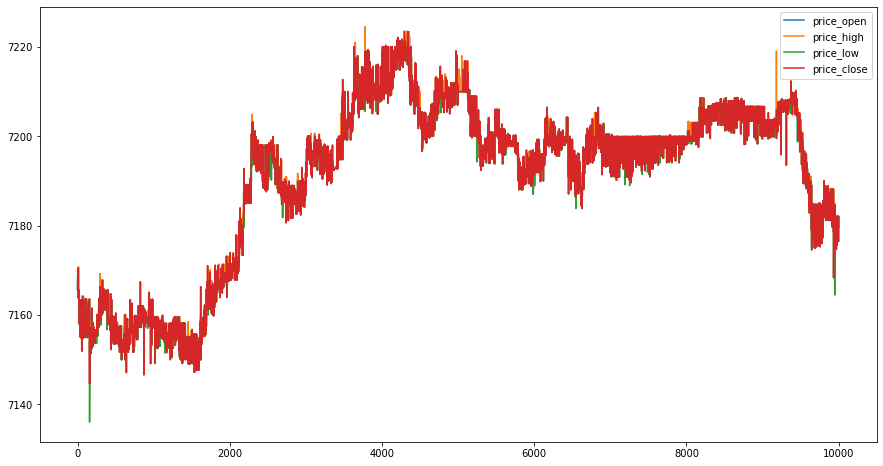

In [8]:
df[["price_open",'price_high','price_low','price_close']].plot(figsize=(15,8))

The figure above shows that timeseries data has an upward trend and some seasnoality.

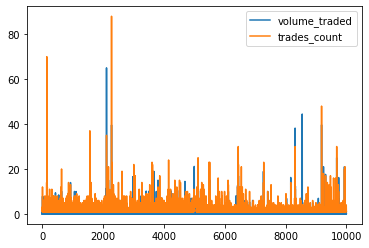

In [9]:
df[['volume_traded','trades_count']].plot()

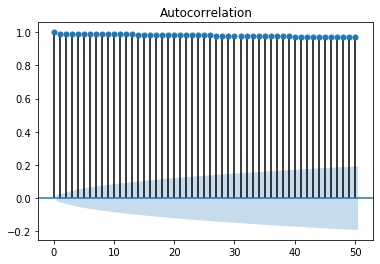

In [10]:
plot_acf(df['price_high'], lags=50, alpha=0.05)
plt.show()

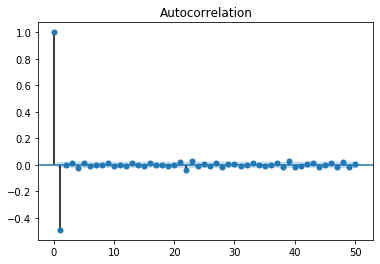

In [11]:
plot_acf(df['price_high'].diff().dropna(), lags=50, alpha=0.05)
plt.show()

Differencing the price_high timeseries could help with making it stationary for the use of various forecasting methods like ARIMA. The autocorrelation plots above for price_high and the first difference of price_high show the lags on  the x-axis and autocorrelation coefficients on the y-axis. Taking the first difference of price_high only has 2 significant lags compared to price_high which correlates with several lagged versions of itself.

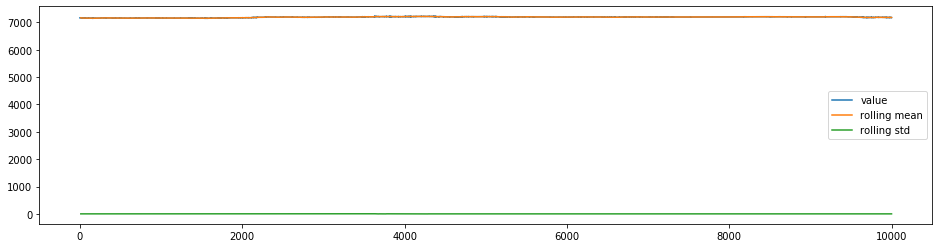

In [12]:
def rolling_stats(timeseries):
#Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label='value')
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std');
    ax.legend()

rolling_stats(df['price_high'])

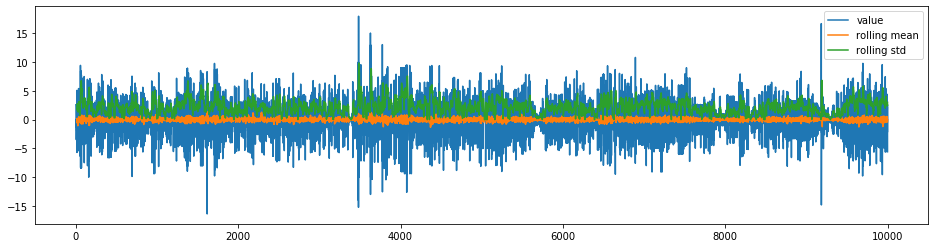

In [13]:
rolling_stats(df['price_high'].diff())

In [14]:
# Augmented Dickey-Fuller Test for stationarity
from statsmodels.tsa.stattools import adfuller

def ADF_test(y):
    dftest = adfuller(y.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))
    print("Non-Stationary") if dftest[1] > 0.05 else print("Stationary")

ADF_test(df['price_high'])

Test statistic = -1.490
P-value = 0.539
Critical values :
	1%: -3.431005015196264 - The data is not stationary with 99% confidence
	5%: -2.8618294777083033 - The data is not stationary with 95% confidence
	10%: -2.5669240838467666 - The data is not stationary with 90% confidence
Non-Stationary


In [15]:
ADF_test(df['price_high'].diff())

Test statistic = -37.687
P-value = 0.000
Critical values :
	1%: -3.431005015196264 - The data is  stationary with 99% confidence
	5%: -2.8618294777083033 - The data is  stationary with 95% confidence
	10%: -2.5669240838467666 - The data is  stationary with 90% confidence
Stationary


Taking the 1st order difference makes the price_high feature stationary, which makes it amendable to use of ARIMA forecasting methods. 

## ML Approach

I aimed to predict price_high using regression model based on the lagged features provided. I will use all features but going forward with a larger dataset over several years (ideally) I might exclude features that were not informative or were highly correlated (depending on the model implemented).

I will use RSME as my main error metric as this will capture the average error between the predictions and actual BTC data. It is in the same unit as the original data.   

I will split the dataset into training(80%) and test (20%). For a more thorough analysis, I would split the training set into 2 (80/20) to have a validation dataset for explicit tuning of hyperparameters (as necessary).

As a start, I established a model performance baseline by using a naive solution where the value from the previous timepoint (in seconds) is used to predict the current value of price_high. This shows us how erroneous a simple model can be and sets the stage for more complex models to beat. I also used the given NN model as a baseline model. 


In [16]:
def lookback(dataset, timesteps = 60):
    # this uses the shift method of pandas dataframes to shift all of the columns down one row
    # and then append to the original dataset
    data = dataset
    for i in range(1, timesteps):
        step_back = dataset.shift(i).reset_index()
        step_back.columns = ['index'] + [f'{column}_-{i}' for column in dataset.columns if column != 'index']
        data = data.reset_index().merge(step_back, on='index', ).drop('index', axis=1)
        
    return data.dropna()
        
features = lookback(df)
features

,price_open,price_high,price_low,price_close,volume_traded,trades_count,price_open_-1,price_high_-1,price_low_-1,price_close_-1,...,price_low_-58,price_close_-58,volume_traded_-58,trades_count_-58,price_open_-59,price_high_-59,price_low_-59,price_close_-59,volume_traded_-59,trades_count_-59
59,7154.97,7154.97,7154.97,7154.97,2.000000,2,7163.30,7163.30,7163.30,7163.30,...,7168.30,7168.30,1.000000,2.0,7165.72,7165.72,7165.71,7165.71,0.021841,2.0
60,7161.20,7163.40,7161.20,7163.40,0.015800,2,7154.97,7154.97,7154.97,7154.97,...,7170.50,7170.50,0.002000,1.0,7168.30,7168.30,7168.30,7168.30,1.000000,2.0
61,7154.98,7154.98,7154.97,7154.98,0.038357,3,7161.20,7163.40,7161.20,7163.40,...,7169.20,7169.20,0.004000,2.0,7170.50,7170.50,7170.50,7170.50,0.002000,1.0
62,7154.98,7154.98,7154.98,7154.98,0.032201,1,7154.98,7154.98,7154.97,7154.98,...,7169.20,7169.20,0.002000,1.0,7169.20,7169.20,7169.20,7169.20,0.004000,2.0
63,7154.97,7154.97,7154.97,7154.97,2.000000,1,7154.98,7154.98,7154.98,7154.98,...,7165.72,7169.20,0.075433,3.0,7169.20,7169.20,7169.20,7169.20,0.002000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,7179.50,7179.50,7179.50,7179.50,0.013325,1,7179.04,7179.04,7178.23,7178.23,...,7178.64,7178.64,0.006793,1.0,7179.88,7179.88,7179.88,7179.88,0.009628,1.0
9996,7181.67,7181.67,7181.67,7181.67,0.013364,1,7179.50,7179.50,7179.50,7179.50,...,7178.64,7178.64,0.001249,1.0,7178.64,7178.64,7178.64,7178.64,0.006793,1.0
9997,7179.50,7179.50,7179.50,7179.50,0.001526,1,7181.67,7181.67,7181.67,7181.67,...,7178.64,7178.64,0.068287,1.0,7178.64,7178.64,7178.64,7178.64,0.001249,1.0
9998,7182.12,7182.12,7182.12,7182.12,0.013437,1,7179.50,7179.50,7179.50,7179.50,...,7173.77,7173.77,0.008064,1.0,7178.64,7178.64,7178.64,7178.64,0.068287,1.0


In [17]:
# split data into train, test, validate 
y = features['price_high']
X = features.drop('price_high', axis=1)
X_train,y_train = X[:int(0.8*X.shape[0])].reset_index(drop=True), y[:int(0.8*X.shape[0])].reset_index(drop=True) # dataset to train
X_test,y_test = X[int(0.8*X.shape[0]):].reset_index(drop=True),y[int(0.8*X.shape[0]):].reset_index(drop=True) 
print(f"y_train: {len(y_train)}, y_test: {len(y_test)}")

y_train: 7952, y_test: 1989


In [18]:
X.shape

(9941, 359)

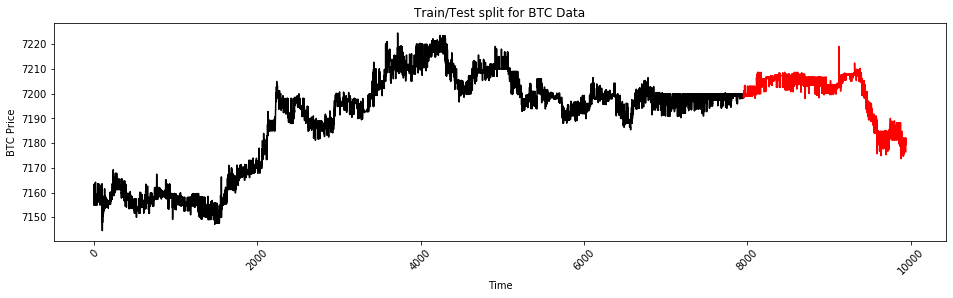

In [19]:
plt.figure(figsize=(16, 4))
plt.plot(y_train, color = "black")
plt.plot(range(int(0.8*X.shape[0]),X.shape[0]),y_test, color = "red")
# plt.plot(y_test, color = "red")
plt.ylabel('BTC Price')
plt.xlabel('Time')
plt.xticks(rotation=45)
plt.title("Train/Test split for BTC Data")
plt.show()

By splitting the data into a trianing and test set, we can be confident that our trained model will generalize to completely new datasets and are not overfit. This suggests that our model could be ready for production (after 1-2 more rounds of testing with new data). We will use the test set (in red) to evaluate the performance of the model. 

# Naive model

Use the previous time point from price_high to predict price_high at the current timepoint. 

In [20]:
pd.concat([X['price_high_-1'],y],axis=1).head(10)

,price_high_-1,price_high
59,7163.30,7154.97
60,7154.97,7163.40
61,7163.40,7154.98
62,7154.98,7154.98
63,7154.98,7154.97
64,7154.97,7154.98
65,7154.98,7163.40
66,7163.40,7155.78
67,7155.78,7155.63
68,7155.63,7163.40


In [21]:
def rmse(y_true,y_pred):
    rmse1 = np.sqrt(np.mean(np.square((y_true.values.reshape(-1, 1) - y_pred))))
    return(rmse1)

In [22]:
rmse(y_train,X_train['price_high_-1'].values) # training RSME

27.211065315729876

In [23]:
rmse(y_test,X_test['price_high_-1'].values) # test RSME

13.313592336387153

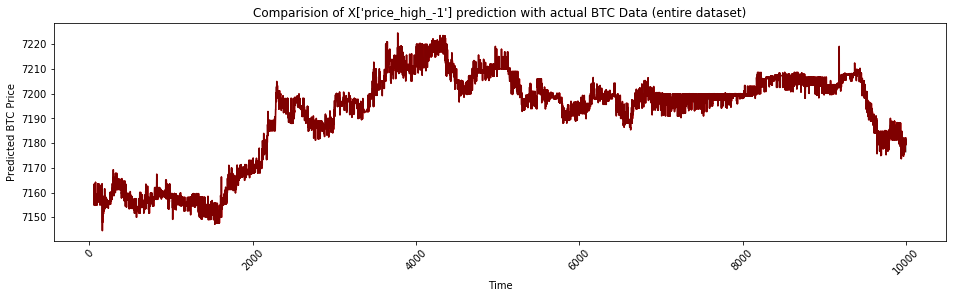

In [24]:
plt.figure(figsize=(16, 4))
plt.plot(X['price_high_-1'], color = "red")
plt.plot(y, color = "black",alpha=0.5)
plt.ylabel('Predicted BTC Price')
plt.xlabel('Time')
plt.xticks(rotation=45)
plt.title("Comparision of X['price_high_-1'] prediction with actual BTC Data (entire dataset)")
plt.show()

# Old NN

Apply NN to X_train data

In [25]:
from keras.models import Sequential
from keras.layers import Dropout, Activation, Dense
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping

In [26]:
#old model
model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1]))
model.add(Dense(16))
model.add(Dense(8))
model.add(Dense(1, activation='relu'))

model.compile(
    loss='mse',
    optimizer=Adam(lr=0.01), # is this the best optimizer/learning rate?
    metrics=['mean_squared_error', 'mean_absolute_error'] # does accuracy make sense in this context?
)

## callbacks but not used
early_stopping = EarlyStopping(
    monitor='val_loss',
    mode='auto',
    restore_best_weights=True
)


history = model.fit(
    X_train,
    y_train,
    validation_split=.3,
    epochs=20,
    verbose=2
)

## prediction
predictions1 = model.predict(X_test)
rmse1 = np.sqrt(np.mean(np.square((y_test.values.reshape(-1, 1) - predictions1))))
rmse1

Epoch 1/20
174/174 - 0s - loss: 194687280.0000 - mean_squared_error: 194687280.0000 - mean_absolute_error: 8158.3701 - val_loss: 51786164.0000 - val_mean_squared_error: 51786164.0000 - val_mean_absolute_error: 7196.2573
Epoch 2/20
174/174 - 0s - loss: 51636176.0000 - mean_squared_error: 51636176.0000 - mean_absolute_error: 7185.7954 - val_loss: 51786164.0000 - val_mean_squared_error: 51786164.0000 - val_mean_absolute_error: 7196.2573
Epoch 3/20
174/174 - 0s - loss: 51636176.0000 - mean_squared_error: 51636176.0000 - mean_absolute_error: 7185.7988 - val_loss: 51786164.0000 - val_mean_squared_error: 51786164.0000 - val_mean_absolute_error: 7196.2573
Epoch 4/20
174/174 - 0s - loss: 51636164.0000 - mean_squared_error: 51636164.0000 - mean_absolute_error: 7185.7974 - val_loss: 51786164.0000 - val_mean_squared_error: 51786164.0000 - val_mean_absolute_error: 7196.2573
Epoch 5/20
174/174 - 0s - loss: 51636168.0000 - mean_squared_error: 51636168.0000 - mean_absolute_error: 7185.7979 - val_loss:

7199.586641806701

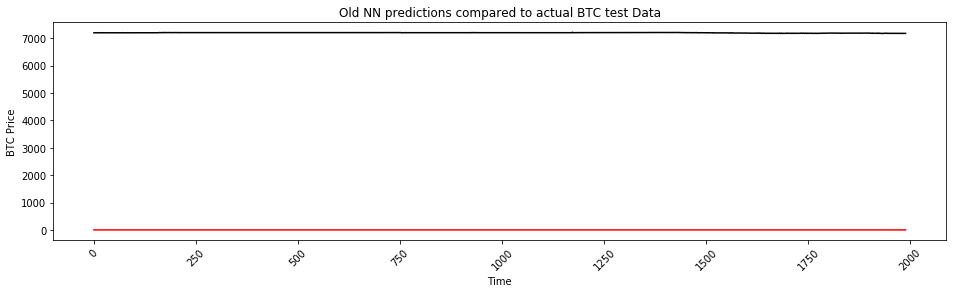

In [27]:
plt.figure(figsize=(16, 4))
plt.plot(y_test, color = "black")
plt.plot(predictions1, color = "red")
plt.ylabel('BTC Price')
plt.xlabel('Time')
plt.xticks(rotation=45)
plt.title("Old NN predictions compared to actual BTC test Data")
plt.show()

Above figure shows that the Old NN produces predictions (in red) (on the X_test set) that are stuck at zero and do not vary with time. The actual price_high data is shown in black from the test set. 

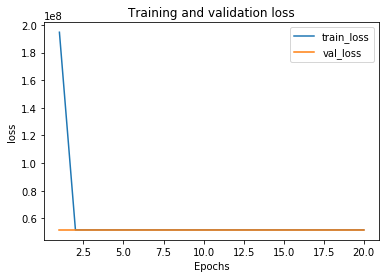

In [28]:
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

plot_metric(history, 'loss')

The above figure shows the training and validation loss of the old NN as it trains over the 20 epochs. Both losses do not vary much from their intial values, which is concerning because we expect both losses to decrease as we proceed through epochs. We can also verify this from the output of cell 26

# New NN

In [29]:
model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(164, activation='relu'))
model.add(Dense(8))
model.add(Dense(1))

model.compile(
    loss='mse',
    optimizer=Adam(lr=0.01), # is this the best optimizer/learning rate?
    metrics=['mean_squared_error'] # does accuracy make sense in this context?
)

## callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    mode='auto',
    restore_best_weights=True
)


history = model.fit(
    X_train,
    y_train,
    validation_split=.3,
    epochs=20,
    verbose=2,
    callbacks=[early_stopping]
)

Epoch 1/20
174/174 - 0s - loss: 2407026.5000 - mean_squared_error: 2407026.5000 - val_loss: 8.4290 - val_mean_squared_error: 8.4290
Epoch 2/20
174/174 - 0s - loss: 9.2216 - mean_squared_error: 9.2216 - val_loss: 4.0821 - val_mean_squared_error: 4.0821
Epoch 3/20
174/174 - 0s - loss: 12.3243 - mean_squared_error: 12.3243 - val_loss: 4.9364 - val_mean_squared_error: 4.9364


In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                11520     
_________________________________________________________________
dense_5 (Dense)              (None, 164)               5412      
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 1320      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 18,261
Trainable params: 18,261
Non-trainable params: 0
_________________________________________________________________


In [31]:
## prediction
predictions = model.predict(X_test)
rmse2 = rmse(y_test,predictions)
rmse2

2.237094838097939

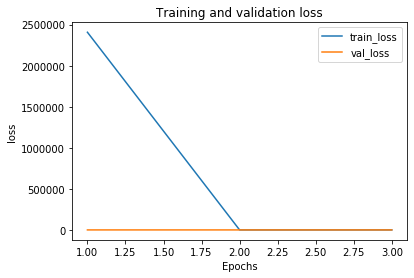

In [32]:
plot_metric(history, 'loss')

Our new NN shows the training loss decreases after 2 epochs, demostarting that the NN is 'learning' how to better predict the target variable. After 3 epochs the NN is stopped from training because there were no gains in validation loss from the previous epoch. 

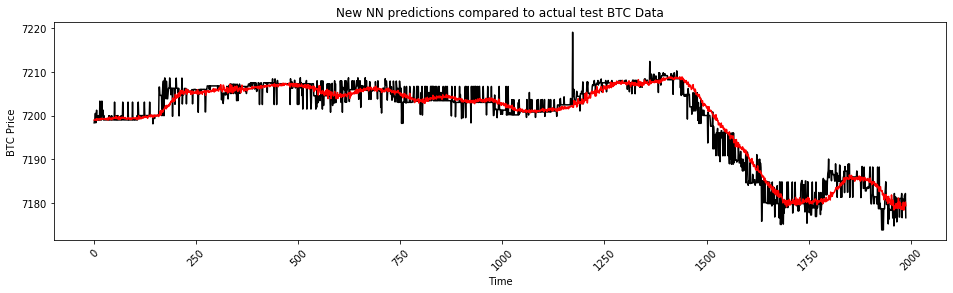

In [33]:
plt.figure(figsize=(16, 4))
plt.plot(y_test, color = "black")
plt.plot(predictions, color = "red")
plt.ylabel('BTC Price')
plt.xlabel('Time')
plt.xticks(rotation=45)
plt.title("New NN predictions compared to actual test BTC Data")
plt.show()

The above figure shows the new NN prediction on the test data (in red) over the actual data (in black). The red line closely approximates the black line over time - rising and falling as expected. The test RMSE (2.2) was much lower than that from the old NN (7199.6) and the naive model (13.3).

## Fit linear regression & xgboost model

In [34]:
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression

In [35]:
%%time
# fit model
lin = LinearRegression()
lin.fit(X_train, y_train)
yhat_lin = lin.predict(X_test)

Wall time: 221 ms


In [36]:
print(f'model R^2 score on training data: {lin.score(X_train, y_train)}')
print(f'model R^2 score on testing data: {lin.score(X_test, y_test)}')

model R^2 score on training data: 0.9994179389357603
model R^2 score on testing data: 0.9955490485210585


In [37]:
rmse(y_test,yhat_lin)

13.312079358482288

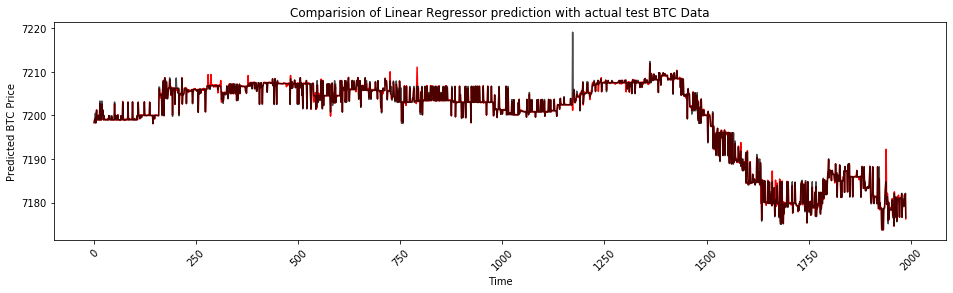

In [38]:
plt.figure(figsize=(16, 4))
plt.plot(yhat_lin, color = "red")
plt.plot(y_test, color = "black",alpha=0.7)
plt.ylabel('Predicted BTC Price')
plt.xlabel('Time')
plt.xticks(rotation=45)
plt.title("Comparision of Linear Regressor prediction with actual test BTC Data")
plt.show()

The predicted values from the Linear regressor closely approximate that of the actual test set - yielding a test RMSE of 13.3, which is not better than the naive or the new NN model but is more interpretable to lay-people.

Text(0.5, 1.0, 'Top 10 Linear Regressor Feature Importances')

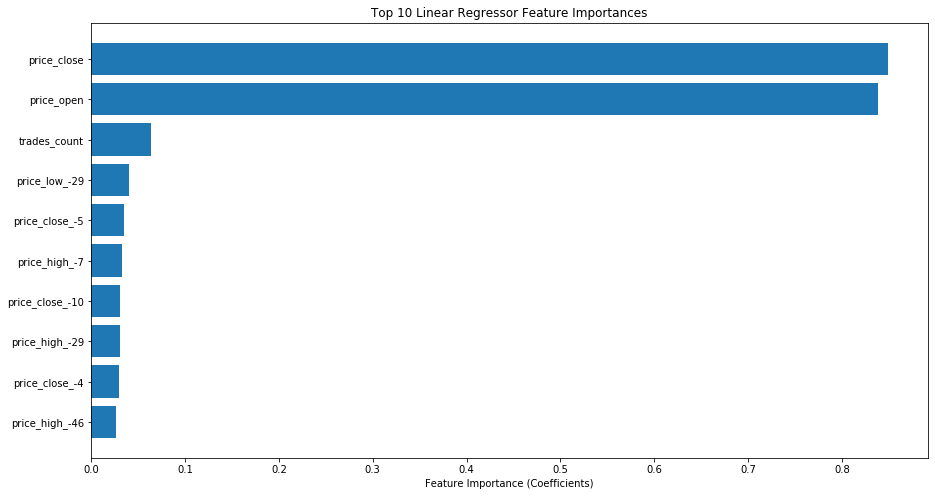

In [39]:
# top 10 important features
# plt.barh(X_train.columns.tolist(), xgb.feature_importances_)
feature_names = X_train.columns.tolist()
sorted_idx = lin.coef_.argsort()[-10:]
plt.figure(figsize=(15,8))
plt.barh([feature_names[ii] for ii in sorted_idx], [lin.coef_[oo] for oo in sorted_idx])
plt.xlabel('Feature Importance (Coefficients)')
plt.title("Top 10 Linear Regressor Feature Importances")

price_close and price_open are important to predicting price_high as evidenced from above. Larger positive coefficient values indicate a larger positive effect on price_high.

In [40]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold

cv_model = cross_validate(
   lin, X_train, y_train, cv=RepeatedKFold(n_splits=5, n_repeats=5),
   return_estimator=True)

coefs = pd.DataFrame(
   [model.coef_
    for model in cv_model['estimator']],
   columns=X_train.columns
)

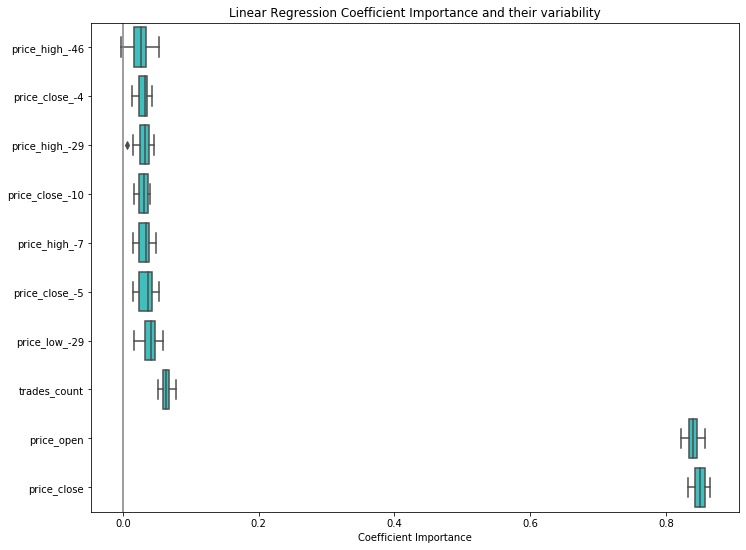

In [41]:
plt.figure(figsize=(15, 9))
sns.boxplot(data=coefs[[feature_names[ii] for ii in sorted_idx]], orient='h', color='cyan', saturation=0.5)
plt.axvline(x=0, color='.5')
plt.xlabel('Coefficient Importance')
plt.title('Linear Regression Coefficient Importance and their variability')
plt.subplots_adjust(left=.3)

## Xgboost
Now I can train xgboost with the entire X_train dataset

In [42]:
%%time
# fit model
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
yhat = xgb.predict(X_test)

Wall time: 8.45 s


In [43]:
rmse(y_test,yhat)

13.486174076916996

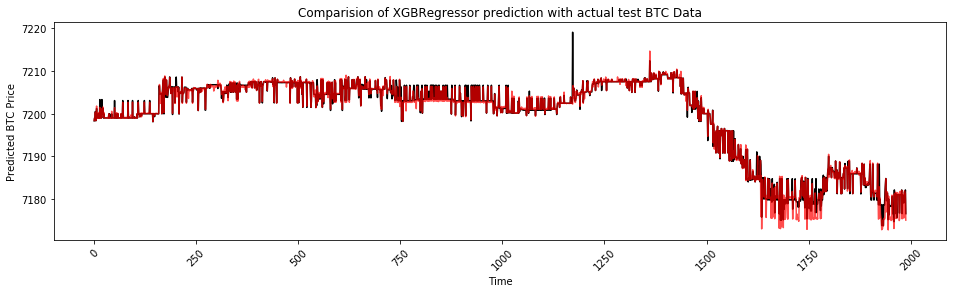

In [44]:
plt.figure(figsize=(16, 4))
plt.plot(y_test, color = "black")
plt.plot(yhat, color = "red", alpha=0.7)
plt.ylabel('Predicted BTC Price')
plt.xlabel('Time')
plt.xticks(rotation=45)
plt.title("Comparision of XGBRegressor prediction with actual test BTC Data")
plt.show()

The above figure shows the actual BTC test data (black line) overlaid over the predicted values (red line) from the xgboost model. It is a good model because the red prediction line closely approximates the black true BTC values - even capturing the step change around timepoint 1500. The overall error of the prediction can be summed up by the RMSE of 13.5, which is much less than the RMSE of 7199.6 that was determined from the original Bitcoin Neural Network model.

Text(0.5, 1.0, 'Top 10 Xgboost Feature Importances')

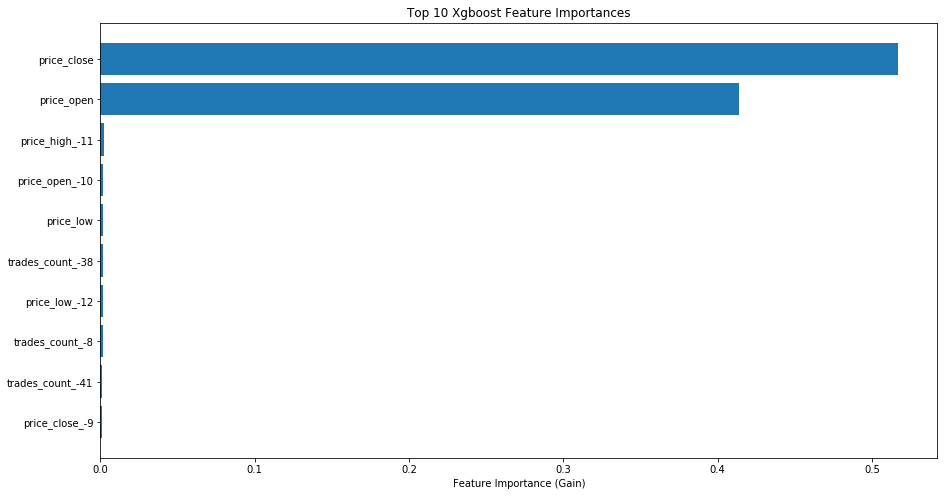

In [45]:
# top 10 important features
# plt.barh(X_train.columns.tolist(), xgb.feature_importances_)
feature_names = X_train.columns.tolist()
sorted_idx = xgb.feature_importances_.argsort()[-10:]
plt.figure(figsize=(15,8))
plt.barh([feature_names[ii] for ii in sorted_idx], [xgb.feature_importances_[oo] for oo in sorted_idx])
plt.xlabel('Feature Importance (Gain)')
plt.title("Top 10 Xgboost Feature Importances")

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


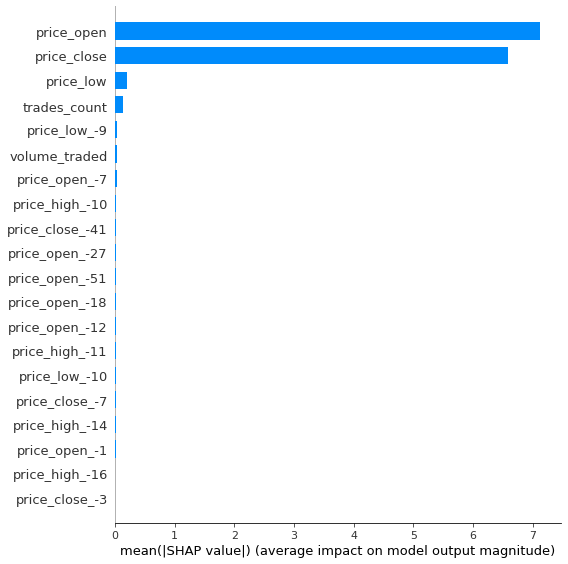

In [46]:
# top 10 important features
import shap
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

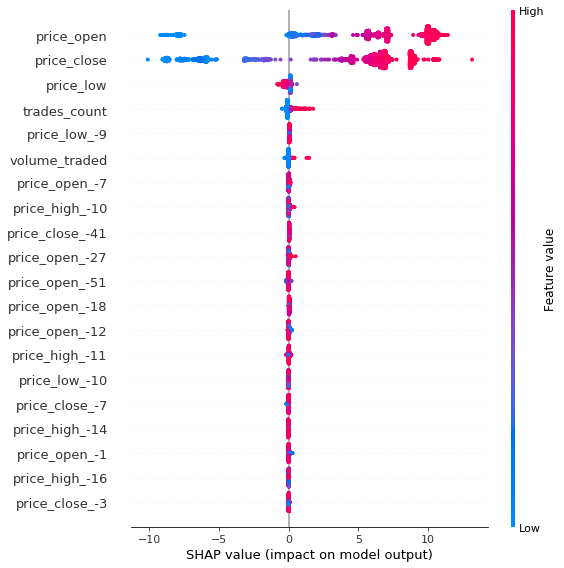

In [47]:
shap.summary_plot(shap_values, X_test)

The above figures illustrate which features are most important for predicting the target variable and how changes in a feature relate to changes in the target variable based on the xgboost model. 

# Alternative Approach: Forecasting using ARIMA

Instead of taking a predition approach, we could take a simpler - univariate forecasting approach i.e. using only previous values of price_high to predict future values by incorporating its seasonality and various moving average trends. This approach assumes stationary (timeseries' mean and variance do not vary over time) data. However, the forecasting approach (as we will  see below) does not capture the variability of the acutal data very well. The ARIMA models below are poor even though they technically yield better RMSEs than the xgboost. If I had more time and data, I would consider other forcasting models or a more thorough tuning of the ARIMA/SARIMA hyperparameters. 

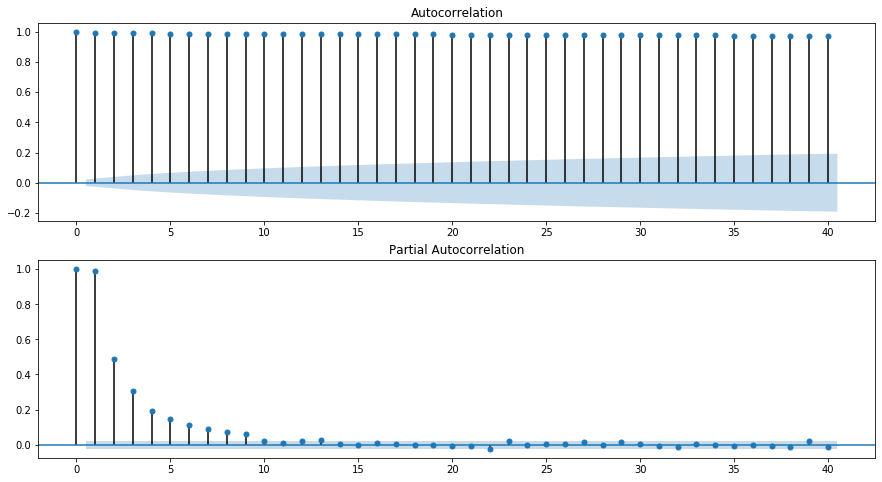

In [48]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(y_train,lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(y_train,lags=40,ax=ax2)

In [49]:
ARIMAmodel = ARIMA(y_train.values, order = (1, 1, 0))
# 1st parameter (p) corresponds to the lagging (past values), 
# 2nd parameter (d) corresponds to differencing, 
# 3rd parameter (q) corresponds to moving average specification/polynomial. 
res = ARIMAmodel.fit()
fcast = res.get_forecast(steps=len(y_test)).summary_frame().reset_index(drop=True)
fcast

y,mean,mean_se,mean_ci_lower,mean_ci_upper
0,7199.149813,2.207252,7194.823678,7203.475948
1,7199.542635,2.476819,7194.688159,7204.397110
2,7199.349794,2.979214,7193.510642,7205.188945
3,7199.444462,3.289424,7192.997309,7205.891614
4,7199.397988,3.624758,7192.293594,7206.502383
...,...,...,...,...
1984,7199.413290,65.976144,7070.102424,7328.724157
1985,7199.413290,65.992753,7070.069872,7328.756709
1986,7199.413290,66.009357,7070.037328,7328.789253
1987,7199.413290,66.025957,7070.004793,7328.821788


In [50]:
print(rmse(y_test,fcast['mean'].values))

9.42268972547294


In [51]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 7952
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -17577.380
Date:                Mon, 11 Apr 2022   AIC                          35158.761
Time:                        12:28:49   BIC                          35172.723
Sample:                             0   HQIC                         35163.541
                               - 7952                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4909      0.007    -74.376      0.000      -0.504      -0.478
sigma2         4.8720      0.049     99.947      0.000       4.776       4.968
===================================================================================
Ljung-Box (Q):                      987.69   Jarque-Bera (JB):              3244.87
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

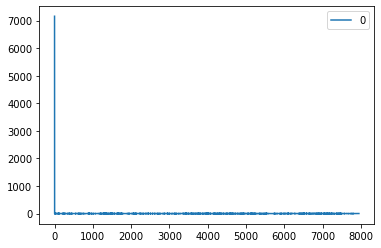

In [52]:
residuals = pd.DataFrame(res.resid)
residuals.plot()

In [53]:
residuals.describe()

,0
count,7952.000000
mean,0.908105
std,80.266341
min,-13.121838
25%,-0.889372
50%,0.000000
75%,0.693450
max,7154.970000


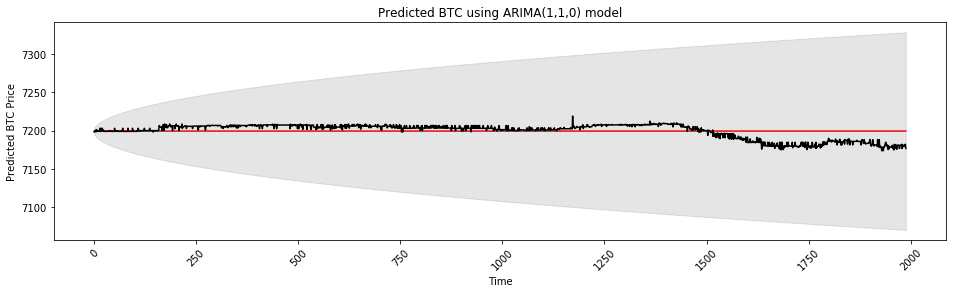

In [54]:
plt.figure(figsize=(16, 4))
plt.plot(fcast['mean'], color = "red")
plt.plot(y_test, color = "black")
plt.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1)
plt.ylabel('Predicted BTC Price')
plt.xlabel('Time')
plt.xticks(rotation=45)
plt.title("Predicted BTC using ARIMA(1,1,0) model")
plt.show()

The ARIMA predictions in red do not vary with the test data (in black) as expected or shown with above NN, Linear regression or xgboost models.